In [2]:
import tqdm
import fasttext
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from transformers import pipeline
from sklearn.ensemble import IsolationForest

C:\Users\Vincelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Load Data & Word Embedding Model

In [22]:
model_path = "Models/cbow_model.bin"
data_path = 'Data\submission_and_comments_V3.csv'
clusters_path = "Data\CBOW_KMeans_TitlesClusters_k=25-50-100-150-200-1000.csv"


all_data = pd.read_csv(data_path, sep = ";", index_col = 0)
model = fasttext.load_model(model_path)
clusters = pd.read_csv(clusters_path)

data = all_data[(all_data.submission_title != "[deleted by user]") & ~(all_data.submission_title.isna())]
concat_posts = np.array(data['submission_title'])

# 2. Load Sentiment Analysis Model

In [4]:
sentiment_pipeline = pipeline(model = "finiteautomata/bertweet-base-sentiment-analysis")

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


# 3. Sentiment Analysis in each cluster

In [5]:
max_length = 260

data_scores = []
for post in tqdm.tqdm(concat_posts):
    dico_sentiment = sentiment_pipeline([post[: max_length]])[0]
    data_scores.append(dico_sentiment)

100%|██████████| 20514/20514 [19:36<00:00, 17.44it/s]


In [27]:
data['sentiment_label'] = [dico['label'] for dico in data_scores]
data['sentiment_score'] = [dico['score'] for dico in data_scores]
data.to_csv('Data/PostTitle_SentimentScore.csv')

C:\Users\Vincelot\AppData\Local\Temp\ipykernel_22744\838485495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment_label'] = [dico['label'] for dico in data_scores]
C:\Users\Vincelot\AppData\Local\Temp\ipykernel_22744\838485495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment_score'] = [dico['score'] for dico in data_scores]


# 4. Sentiment Analysis Per Cluster

## 4.1. Overall Sentiment Distributions

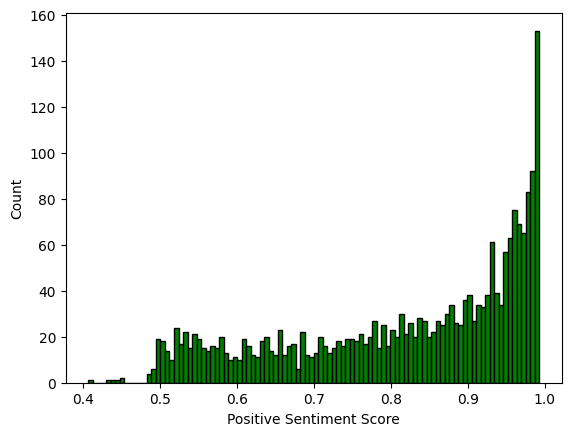

In [7]:
data[data['sentiment_label'] == "POS"]['sentiment_score'].hist(bins = 100, color =  'g', edgecolor = "k")
plt.xlabel('Positive Sentiment Score')
plt.ylabel('Count')
plt.grid(None)

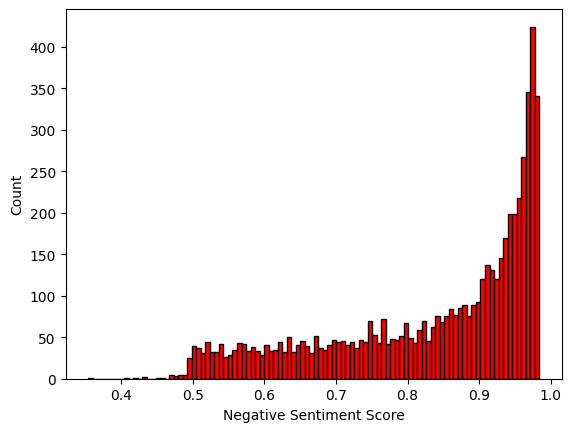

In [8]:
data[data['sentiment_label'] == "NEG"]['sentiment_score'].hist(bins = 100, color =  'r', edgecolor = "k")
plt.xlabel('Negative Sentiment Score')
plt.ylabel('Count')
plt.grid(None)

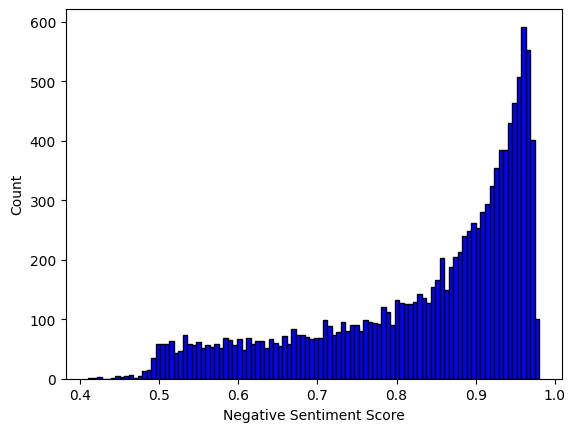

In [9]:
data[data['sentiment_label'] == "NEU"]['sentiment_score'].hist(bins = 100, color =  'b', edgecolor = "k")
plt.xlabel('Negative Sentiment Score')
plt.ylabel('Count')
plt.grid(None)

## 4.2 Analysis Per Cluster

In [28]:
data_clusters = data.copy().reset_index()
data_clusters

,index,submission_id,list_comment_id,submission_title,comments_body,sentiment_label,sentiment_score
0,1,xxnx84,"['ird3wvd', 'irepsfn', 'ird2yz5', 'irdhi3y', '...",Another reason I need to get off social media-...,['It’s actually really common and one of the m...,NEG,0.945326
1,2,xxhvlu,"['irdrh1k', 'ircrlhp', 'ireb73u', 'ire27fr', '...",Having a flip phone changed my life (for good),['yup. changed my life. Quite literally went f...,POS,0.980623
2,4,xx655y,"['irbvkr9', 'ira6cfu']",The ultimate nosurf solution by using timer so...,"['These solutions are great, and pretty impact...",NEU,0.888417
3,5,xx49wn,"['irab0kn', 'ira5129', 'irb9k5a', 'irbae85', '...",I'm thankful for ads,"[""This has helped me with Instagram, I didn't ...",POS,0.939955
4,6,xx3xu4,['ir9ti1g'],"On Silence (and creativity), a short essay by ...","[""Attention all newcomers: Welcome to /r/nosur...",NEU,0.961295
...,...,...,...,...,...,...,...
20509,22138,k06gb,['c2gpr7w'],Joining the no surf september challenge,"[""Good luck! Love to hear how it's going. (A...",NEU,0.925098
20510,22139,k00gg,['c2glbtf'],1st report for my September Challenge,['I might try it!'],NEU,0.960916
20511,22140,jzl9s,"['c2gdoo5', 'c2gpnkx', 'c2gh9lv', 'c2ge8nr', '...",Suggest software to make the nosurf experience...,['[Chrome nanny](https://chrome.google.com/web...,POS,0.658036
20512,22141,jzdcl,"['c2gcbdx', 'c2ges0p', 'c2gfsvy', 'c2ghqbi']",No Surf September,"['good luck! ', 'This is a great challenge. Pr...",NEU,0.782461


In [76]:
data_clusters['cluster_100'] = clusters["KMeans_k=100"]
#data_clusters[data_clusters.sentiment_label == "POS"][['cluster_100','sentiment_score']].groupby('cluster_100').median()['sentiment_score'].hist(bins=100)
pd.options.display.max_colwidth = 100
cluster_id = data_clusters['cluster_100'].unique()[6]
cluster_id_data = data_clusters[data_clusters['cluster_100'] == cluster_id]
cluster_id_data[cluster_id_data['sentiment_label'] == 'NEG'][['submission_title', 'sentiment_score', 'cluster_100']].sort_values(by = 'sentiment_score', ascending = False)

,submission_title,sentiment_score,cluster_100
18450,Too much anxiety. Too much unstable moods. I don't want to do this anymore.,0.982120,30
17820,Ugh. I couldn't even make it one night.,0.981918,30
6403,My phone broke about 2 weeks ago. I no longer care about them,0.981706,30
1921,This is stupid. What the fuck am I even doing here?,0.981512,30
8343,Why does the internet suck so much these days? I feel like a mindless zombie!,0.981113,30
1684,I keep coming back to the miserable piece of shit on Twitter and I can’t stop,0.981112,30
12881,I can't stand Reddit anymore. How do I stop using it so much?,0.980993,30
1653,I am slowly starting to lose RESPECT for Reddit,0.980879,30
106,I found a loophole to acces websites blocked with cold turkey and i spend so much time there aga...,0.980765,30
8950,"stupid rant. everyone around me, including me, is stuck in this digital prison and i don't know ...",0.980410,30
